# Bank Marketing ML Project

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import joblib

sns.set(style="whitegrid")

csv_path = "C:/Users/radmi/Desktop/jupyter notebook/Project/bank-additional-full.csv"
data = pd.read_csv(csv_path, sep=';')

# Анализ структуры данных
print("Размер датасета:", data.shape)
data.info()
data.describe()

Размер датасета: (41188, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  co

## Распределение целевой переменной

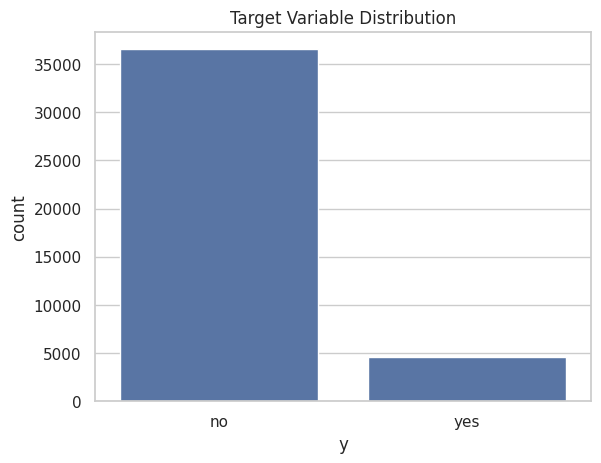

In [11]:
data['y'].value_counts(normalize=True)
sns.countplot(x='y', data=data)
plt.title('Target Variable Distribution')
plt.show()

## Анализ категориальных признаков

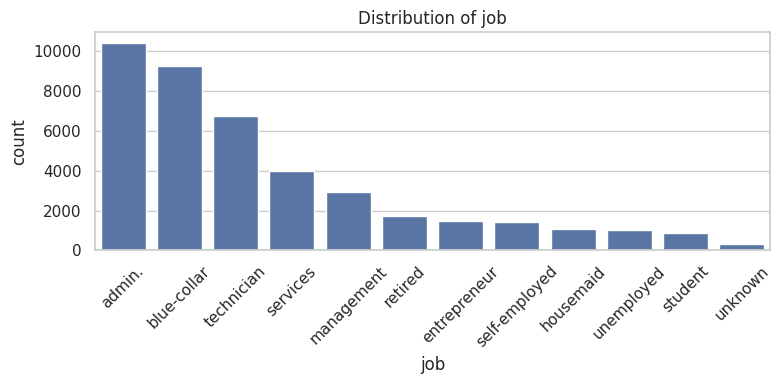

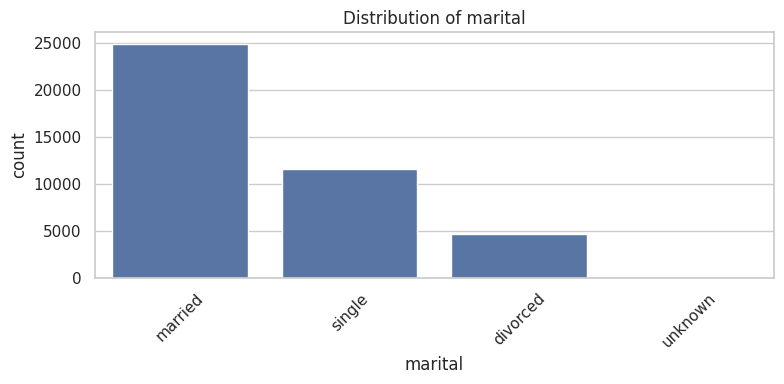

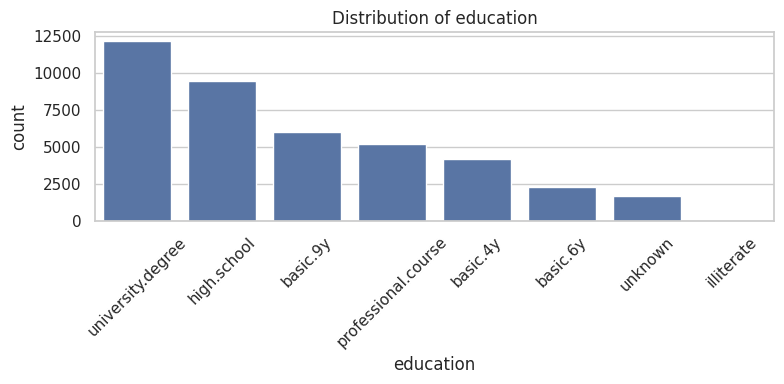

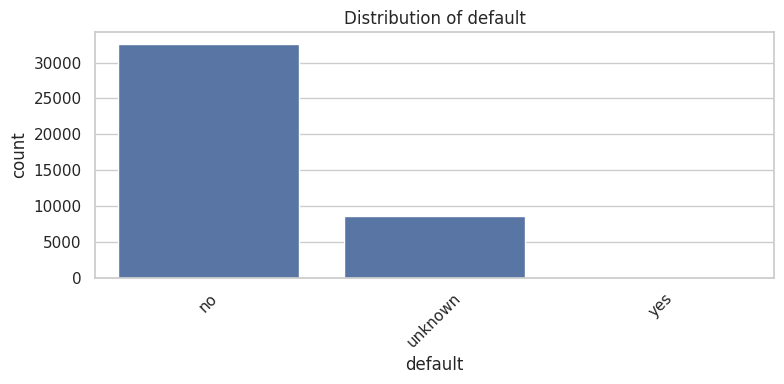

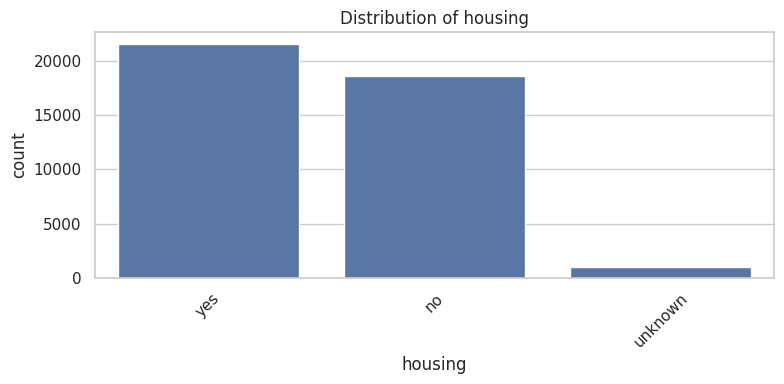

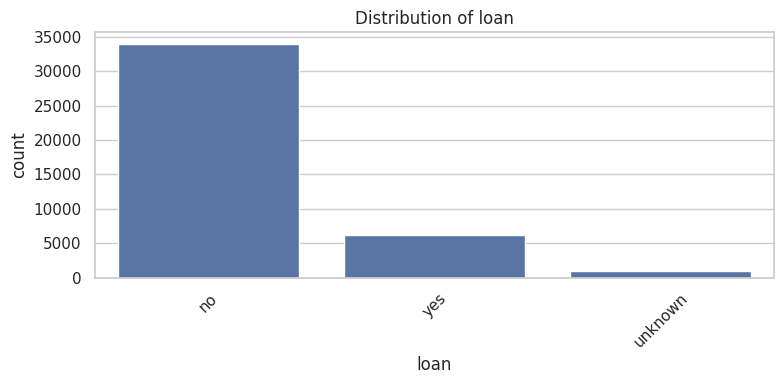

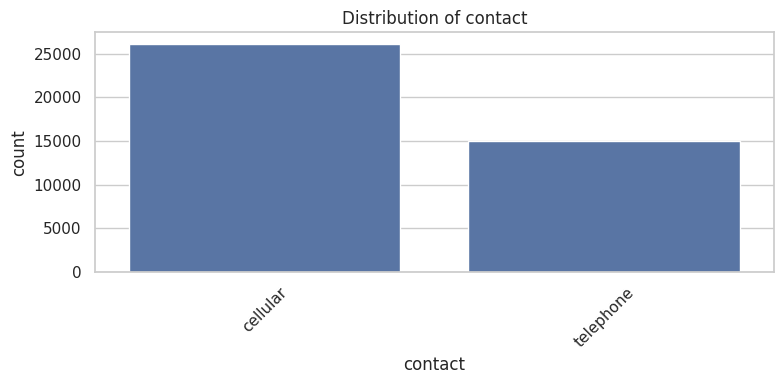

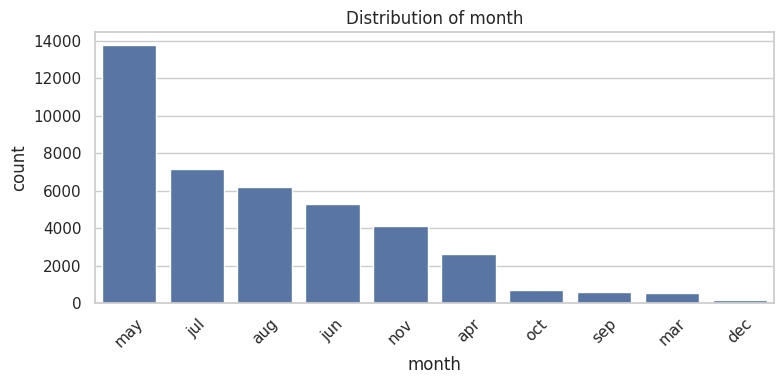

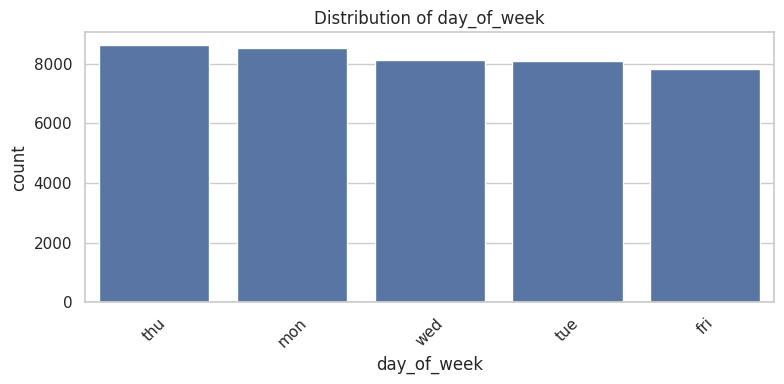

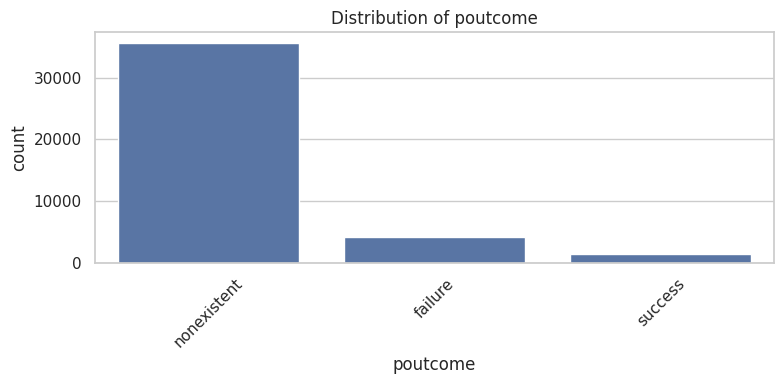

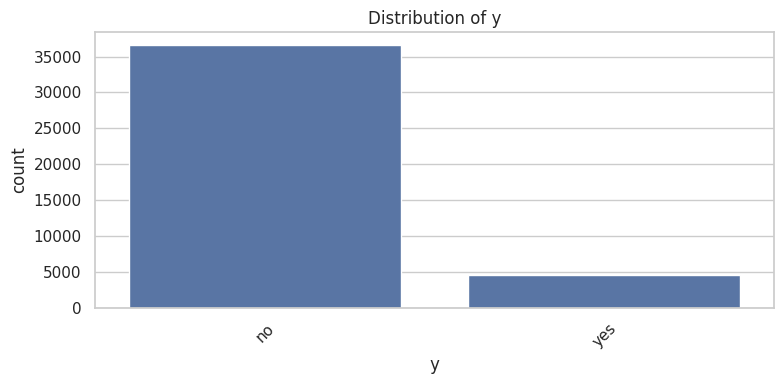

In [12]:
categorical_cols = data.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=data, order=data[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

##Корреляционная матрица для числовых признаков:

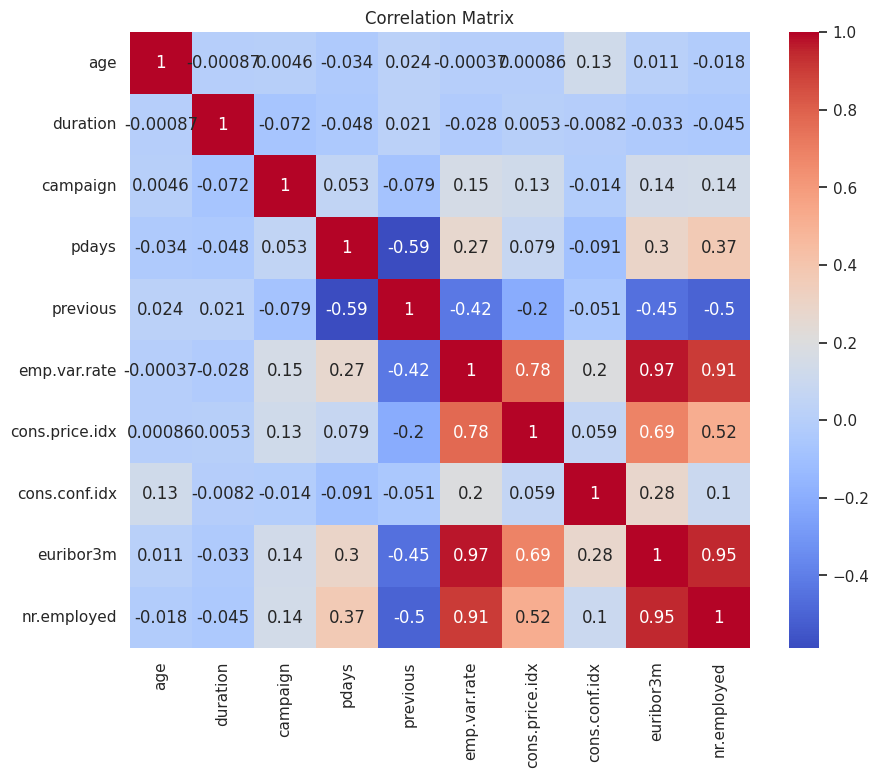

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

## Предобработка

In [13]:
X = data.drop('y', axis=1)
y = data['y'].map({'yes': 1, 'no': 0})

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Модели для сравнения

In [14]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, clf in models.items():
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('clf', clf)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print(f"\n{name}:")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", auc)
    results[name] = {
        'model': pipeline,
        'auc': auc,
        'fpr': roc_curve(y_test, y_proba)[0],
        'tpr': roc_curve(y_test, y_proba)[1]
    }


Logistic Regression:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7310
           1       0.71      0.44      0.54       928

    accuracy                           0.92      8238
   macro avg       0.82      0.71      0.75      8238
weighted avg       0.91      0.92      0.91      8238

ROC AUC: 0.9424372906740885

Random Forest:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      7310
           1       0.71      0.48      0.57       928

    accuracy                           0.92      8238
   macro avg       0.82      0.73      0.76      8238
weighted avg       0.91      0.92      0.91      8238

ROC AUC: 0.9456124109627813

Gradient Boosting:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      7310
           1       0.70      0.54      0.61       928

    accuracy                           0.92      8238
   macro avg  

## Визуализация ROC-кривых

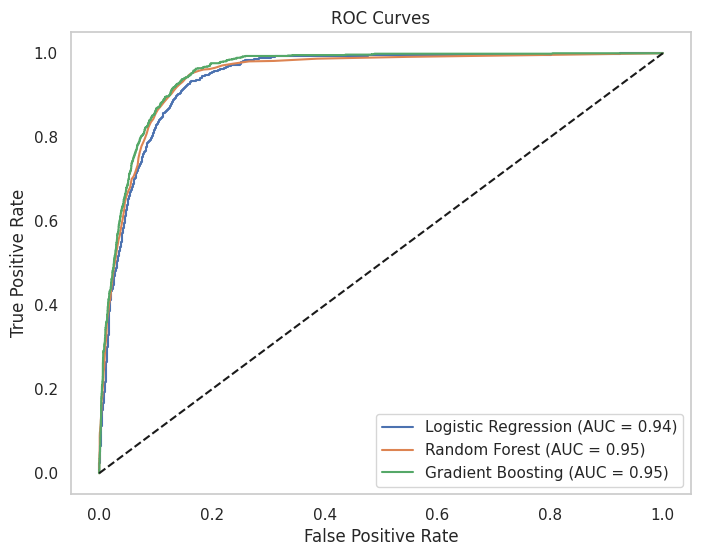

In [16]:
# Визуализация ROC-кривых
plt.figure(figsize=(8, 6))
for name, res in results.items():
    plt.plot(res['fpr'], res['tpr'], label=f"{name} (AUC = {res['auc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid()
plt.show()

## Сохранение лучшей модели (по AUC)

In [17]:
best_model_name = max(results, key=lambda name: results[name]['auc'])
best_model = results[best_model_name]['model']
model_filename = f"best_model_{best_model_name.replace(' ', '_').lower()}.pkl"
joblib.dump(best_model, model_filename)
print(f"Лучшая модель сохранена в файл: {model_filename}")

Лучшая модель сохранена в файл: best_model_gradient_boosting.pkl
